<a href="https://colab.research.google.com/github/KubaSiwiec/hsi_spatial_spectral/blob/collab/HOG_LBP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
'''
feature extraction functions
'''

import scipy.io
from skimage.util import view_as_windows
from skimage.util import pad
import numpy as np
from skimage.feature import local_binary_pattern, hog


def get_data(file_name):
    return scipy.io.loadmat(file_name)

def get_patches(image, size = 3, use_padding = 'SAME'):

    # add padding for image to make it able to extract the number of patches equal to number of pixels
    # the pad width should eqal (patch size - 1) / 2,  - center pixel will always lay in original image
    nb_padding_pixels = int(size/2 - 0.5)
    # choose symmetric mode
    image_padded = pad(image, nb_padding_pixels, 'symmetric')

    patch_size = (size, size, image.shape[2])
    patches = view_as_windows(image_padded, patch_size)[:, :, 0]
    return patches

def hsi_to_lbp(image, radius, n_points):

    image_shape = image.shape
    image_depth = image_shape[2]


    lbp_map = np.zeros(image.shape)
    
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        lbp_map[:, :, k] = local_binary_pattern(image[:, :, k], n_points, radius)

    return lbp_map

def hsi_to_hog(image):

    image_shape = image.shape
    image_depth = image_shape[2]

    hog_desc_lst = []
    hog_img_lst = []

    
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        desc, hog_img = hog(image[:, :, k], visualize = True)
        hog_desc_lst.append(desc)
        hog_img_lst.append(hog_img)

    hog_desc_arr = np.asarray(hog_desc_lst)
    hog_img_arr = np.asarray(hog_img_lst)

    hog_img_arr = np.swapaxes(hog_img_arr, 0,1)
    hog_img_arr = np.swapaxes(hog_img_arr, 1,2)
    hog_desc_arr = np.swapaxes(hog_desc_arr, 0,1)

    return hog_desc_arr, hog_img_arr





def hs_to_grey(image):
    return np.mean(image, axis = 2)

def arr2D_to_list(arr: np.array):
    dims = len(arr.shape)
    lst = []
    if dims == 2:
        print('Gt width: {}, length: {}'.format(arr.shape[0], arr.shape[1]))
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                lst.append(arr[i, j])

        return lst
    else:
        raise Exception('Array should be two dimentional')

def arr5D_to_list_of_3D_arr(arr: np.array):
    dims = len(arr.shape)
    lst = []
    if dims == 5:
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                    lst.append(arr[i, j])
        return lst
    else:
        raise Exception('Array should be two dimentional')





In [3]:
import gc
class GarbageCollectorCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    gc.collect()


In [4]:
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt

In [5]:
mat = get_data("/content/drive/My Drive/PaviaU.mat")

mat_gt = get_data("/content/drive/My Drive/PaviaU_gt.mat")

mat_training = get_data("/content/drive/My Drive/PaviaU_tr.mat")


data = mat['paviaU']
ground_t = mat_gt['paviaU_gt']
ground_truth = ground_t.flatten()
training_data_full = mat_training['PaviaUni_train'].flatten()

training_indeces = np.asarray(np.where(training_data_full > 0))
testing_indices = np.asarray(np.where(ground_truth > 0))

training_labels = np.take(training_data_full, training_indeces, axis = 0).flatten()
testing_labels = np.take(ground_truth, testing_indices, axis = 0).flatten()


print("Shape of the cube: {}".format(data.shape))
print("Shape of the labels_array: {}".format(ground_truth.shape))
print("Shape of training labels array: {}".format(training_data_full.shape))
print("Shape of training indeces array: {}".format(training_indeces.shape))
print("Training labels classes: {}".format(np.unique(training_labels)))
print("Number of classes: {}".format(np.unique(ground_truth)))
print("Shape of testing indices array: {}".format(testing_indices.shape))
print("Shape of testing labels array: {}".format(testing_labels.shape))





print("Maximum value: {}".format(np.argmax(data)))

print("Index of maximum value: {}".format(np.unravel_index(np.argmax(data), data.shape)))













Shape of the cube: (610, 340, 103)
Shape of the labels_array: (207400,)
Shape of training labels array: (207400,)
Shape of training indeces array: (1, 3921)
Training labels classes: [1 2 3 4 5 6 7 8 9]
Number of classes: [0 1 2 3 4 5 6 7 8 9]
Shape of testing indices array: (1, 42776)
Shape of testing labels array: (42776,)
Maximum value: 396299
Index of maximum value: (11, 107, 58)


In [6]:
data = np.int_(data / np.max(data) * 255)
print(data)

[[[ 20  15  14 ... 102 103 103]
  [ 19  17  16 ...  77  78  80]
  [ 19  23  17 ...  73  74  75]
  ...
  [ 16  16  19 ...  93  93  94]
  [ 16  10   2 ...  87  88  90]
  [ 22  15  13 ...  81  80  79]]

 [[ 22  21  21 ...  83  83  83]
  [ 28  22  14 ...  50  49  48]
  [ 17  16  19 ...  48  48  49]
  ...
  [ 36  20  13 ... 103 103 104]
  [ 29  32  23 ...  90  89  89]
  [ 33  27  17 ...  79  80  80]]

 [[ 34  27  22 ...  67  69  69]
  [ 10  16  19 ...  35  35  34]
  [ 33  21  10 ...  25  25  25]
  ...
  [ 25  22  15 ...  88  88  90]
  [  7  11  19 ...  91  91  91]
  [ 26  18  15 ...  89  89  89]]

 ...

 [[ 23  19  22 ...  69  69  69]
  [ 25  25  31 ...  62  63  62]
  [ 26  26  29 ...  60  61  62]
  ...
  [ 22  22  21 ...  76  76  74]
  [ 11   9   0 ...  78  78  77]
  [ 36  29  22 ...  79  80  80]]

 [[ 25  23  27 ...  69  69  69]
  [ 27  28  22 ...  67  68  68]
  [ 34  35  35 ...  62  63  65]
  ...
  [ 22  23  17 ...  81  81  81]
  [ 17  16  14 ...  79  78  77]
  [ 24  19   9 ...  76  77  

In [7]:
# apply hog on image
radius = 3
hog_desc, processed_image_hog = hsi_to_hog(data)
processed_image_lbp = hsi_to_lbp(data, radius, radius * 8)

In [8]:
processed_image_hog = np.int_(processed_image_hog/np.max(processed_image_hog)*255)
processed_image_lbp = np.int_(processed_image_lbp/np.max(processed_image_lbp)*255)

processed_image = np.dstack((processed_image_hog, processed_image_lbp))

print(processed_image.shape)
print(processed_image)
print(np.max(processed_image))

(610, 340, 206)
[[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...  12  12  12]
  [  0   0   0 ...   7   7   7]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  1   0   3 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...  12  12  12]
  [  0   0   0 ...   7   7   7]]

 [[  0   0   0 ...   0   0   0]
  [  4   5   3 ...   5   5   5]
  [  0   0   0 ... 254 254 254]
  ...
  [  0   0   0 ...  31  31  31]
  [  0   0   0 ...  15  15  15]
  [  0   0   0 ...   7   7   7]]

 ...

 [[  0   0   0 ... 191 191 191]
  [  0   0   0 ... 191 191 223]
  [  0   0   0 ... 223 223 223]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ... 127 127 127]
  [  0   0   0 ... 127 127 127]
  [  0   0   0 ... 127 127 127]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0  

In [9]:
print('HOG image shape: {}'.format(processed_image.shape))

HOG image shape: (610, 340, 206)


In [10]:
np.max(processed_image)

255

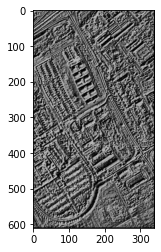

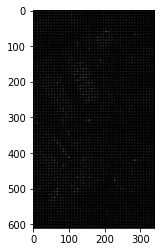

In [11]:
plt.figure(1)
plt.imshow(hs_to_grey(processed_image), cmap='gray')
plt.show()

plt.figure(2)
plt.imshow(processed_image[:, :, 0], cmap='gray')
plt.show()

In [12]:
print(hog_desc.shape)

(239760, 103)


In [13]:
#crop patches
patch_size = 19
data_patches = get_patches(processed_image, patch_size)
print('HOG patches shape: {}'.format(data_patches.shape))

HOG patches shape: (610, 340, 19, 19, 206)


In [14]:
'''
Save patches and ground truth into arrays
'''
training_patch_arr = np.resize(np.take(np.asarray(arr5D_to_list_of_3D_arr(data_patches), dtype=np.uint8), training_indeces, axis = 0), (training_labels.shape[0], patch_size, patch_size, 206))
testing_patch_arr = np.resize(np.take(np.asarray(arr5D_to_list_of_3D_arr(data_patches), dtype=np.uint8), testing_indices, axis = 0), (testing_labels.shape[0], patch_size, patch_size, 206))

print(testing_patch_arr.shape)
print('patch_lbp_list len: {}'.format(training_patch_arr.shape))
gc.collect()

# ground truth
labels_gt = ground_truth.flatten()
print("Labels len: {}".format(len(labels_gt)))
print(np.unique(labels_gt))
# ground_truth = None

(42776, 19, 19, 206)
patch_lbp_list len: (3921, 19, 19, 206)
Labels len: 207400
[0 1 2 3 4 5 6 7 8 9]


In [15]:
pip install spectral

ImageView object:
  Display bands       :  [0, 51.5, 102]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 255.0]
    G: [0.0, 255.0]
    B: [0.0, 255.0]

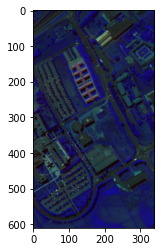

In [16]:
import spectral
spectral.imshow(data)

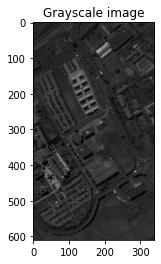

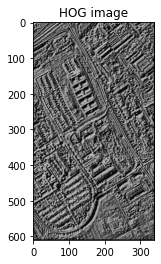

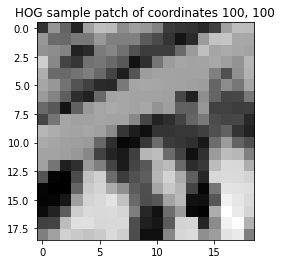

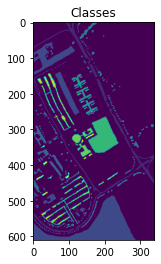

In [17]:
'''
Plotting images
'''

#compare greyscale image with lbp map
plt.figure(1)
plt.imshow(hs_to_grey(data), cmap='gray')
plt.title("Grayscale image")

plt.figure(2)
plt.imshow(hs_to_grey(processed_image), cmap='gray')
plt.title("HOG image")

# present some patches of lbp data
plt.figure(4)
co_x = 100
co_y = 100
plt.imshow(hs_to_grey(data_patches[co_x, co_y]), cmap='gray')
plt.title("HOG sample patch of coordinates {}, {}".format(co_x, co_y))

plt.figure(6)
plt.imshow(ground_t)
plt.title('Classes')

plt.show()

#free memory
data = None
processed_image = None

9803

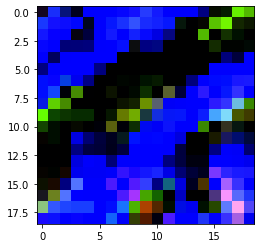

In [18]:
spectral.imshow(data_patches[co_x, co_y])
co_x = None
co_y = None
gc.collect()

In [19]:
'''
split data to training and validation datasets
'''
gc.collect()

val_split = 0.12
X_train, X_val, y_train, y_val = train_test_split(testing_patch_arr, testing_labels, test_size=val_split, stratify=testing_labels)
label_gt = None

In [20]:
training_patch_arr.shape

(3921, 19, 19, 206)

In [21]:
'''
create CNN model function
'''
from tensorflow import keras

# model definition function
def create_model_CNN(l2_loss_lambda = None):
    keras.backend.clear_session()

    target_size = (32, 32)
    l2 = None if l2_loss_lambda is None else keras.regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)

    model = keras.Sequential(
        [
            keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)),
            keras.layers.Conv2D(256, 3, activation=tf.nn.relu, input_shape=(32, 32, 206)),
            keras.layers.MaxPool2D(2),
            keras.layers.Conv2D(512, 3, activation=tf.nn.relu),
            keras.layers.MaxPool2D(2),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=l2),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(10, activation=tf.nn.softmax),
        ]
    )

    # model compiling

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [ ]:
'''
Create and fit model, get loss, accuracy and f1-score metrics
'''
model = create_model_CNN(0.01)

gc.collect()
history = model.fit(X_train, y_train, batch_size = 128, epochs=20, validation_data=(X_val, y_val))

# history = model.fit_generator(train_generator, epochs=700, validation_data=validation_generator)

print(model.summary())

Using L2 regularization - l2_loss_lambda = 0.0100
Epoch 1/20
295/295 [==============================] - 35s 118ms/step - loss: 23.3239 - accuracy: 0.7848 - val_loss: 6.3218 - val_accuracy: 0.9402
Epoch 2/20
295/295 [==============================] - 35s 118ms/step - loss: 5.2400 - accuracy: 0.9512 - val_loss: 4.3336 - val_accuracy: 0.9712
Epoch 3/20
295/295 [==============================] - 35s 117ms/step - loss: 3.7567 - accuracy: 0.9709 - val_loss: 3.2088 - val_accuracy: 0.9869
Epoch 4/20
295/295 [==============================] - 35s 117ms/step - loss: 2.8688 - accuracy: 0.9744 - val_loss: 2.5339 - val_accuracy: 0.9883
Epoch 5/20
295/295 [==============================] - 35s 117ms/step - loss: 2.1914 - accuracy: 0.9824 - val_loss: 1.9276 - val_accuracy: 0.9844
Epoch 6/20
295/295 [==============================] - 35s 118ms/step - loss: 1.7840 - accuracy: 0.9783 - val_loss: 1.4875 - val_accuracy: 0.9945
Epoch 7/20
295/295 [==============================] - 35s 119ms/step - loss: 1.

In [ ]:
'''
Plot accuracy
'''

plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.title("HOG, LSTM, {}x{} patch".format(patch_size, patch_size))
plt.show()

In [ ]:
'''
get predictions and predicted labels for validation set
'''

predictions = model.predict(X_val)
gt_predicted = [np.argmax(prediction) for prediction in predictions]


In [ ]:
'''
Calculate kappa coefictient
'''

from sklearn.metrics import cohen_kappa_score, f1_score

kappa = cohen_kappa_score(y_val, np.array(gt_predicted))
f1 = f1_score(y_val, np.array(gt_predicted), average = 'weighted')
print("Training accuracy: {}\nValidation accuracy: {}\nKappa: {}\nF1: {}".format(np.max(history.history['accuracy']), np.max(history.history['val_accuracy']),kappa, f1))

In [ ]:
predictions_test = model.predict(training_patch_arr)
gt_predicted_test = [np.argmax(prediction) for prediction in predictions_test]

In [ ]:
result = model.evaluate(training_patch_arr, training_labels)

kappa_test = cohen_kappa_score(training_labels, np.array(gt_predicted_test))
f1_test = f1_score(training_labels, np.array(gt_predicted_test), average = 'weighted')
print("Testing loss and accuracy: {}\nKappa: {}\nF1: {}".format(result,kappa_test, f1_test))
